# 6. Implementación en Punto Fijo

Los ejemplos considerados hasta el momento implican cálculos con cantidades flotantes. Aunque este tipo de implementación es ideal para procesadores que soporten aritmética en punto flotante tal como un PC o un DSP especializado, éstas no son eficientes para un arquitectura que soporte exclusivamente aritmética entera como es el caso de un microcontrolador. Para este tipo de plataformas es necesario modificar los algoritmos para emular el punto flotante a través del **punto fijo**. 

En la siguiente tabla se presentan los sistemas de desarrollo de sistemas embebidos más populares en la actualidad indicando lo que soportan unidad de punto flotante (FPU: _Floating-point unit_) de forma nativa. En los dispositivos que no tienen FPU, se pueden conseguir desempeños superiores al aplicar punto fijo. Incluso en algunas arquitecturas que suporten FPU, usar punto fijo permite acelerar los cálculos cuando la CPU cuenta con unidades de ejecución en paralelo que soporten estrategias como _loop-unrolling_ que se estudiarán en otro capítulo.

| Tarjeta de desarrollo | CPU | Bits | FPU |
|------|------|------|------|
| Arduino UNO	| ATmega328P | 8 | No |
| Arduino NANO	| ATmega328 | 8 | No |
| Arduino MEGA	| ATmega2560 | 8 | No | 
| Arduino DUE	| Atmel SAM3X8E ARM Cortex-M3 | 32 | No |
| ESP8266 | Tensilica Diamond L106 | 32 | No |
| ESP32	| Xtensa dual-core LX6 | 32 | Sí (Precisión simple) |
| ESP32-S2	| Xtensa single-core LX7 | 32 | No |
| ESP32-S3	| Xtensa dual-core LX7 | 32 | Sí (Precisión simple) |
| ESP32-C2 | RISC-V single-core RV32IMC | 32 | No |
| ESP32-C3 | RISC-V single-core RV32IMC | 32 | Sí (Precisión simple) |

El punto fijo se basa en el escalamiento en amplitud de los coeficientes de las ecuaciones en diferencia, permitiendo su representación y almacenamiento en cantidades enteras con signo y la realización de todos los cálculos, tales como sumas y productos, con instrucciones de aritmética entera con signo. Para realizar este escalamiento se escoge un factor potencia de dos $2^{F}$. De esta forma, el nuevo conjunto de coeficientes, en representación en punto fijo es el resultado del redondeo del producto entre el coeficiente original $c$ y el **factor de escalamiento**

$$c_{p}=Q\{(2^{F}-1)\times c\}$$

donde $Q\{x\}$ representa la operación de redondeo al entero más próximo. La elección de un factor de escalamiento potencia de dos se hace con el fin de que su efecto pueda ser eliminado con un desplazamiento aritmético hacia la derecha, que emula la división. La resta del número 1 se hace con el fin de que el número $c=1.0$ pueda ser expresado sin problemas de desborde en una representación entera de n bits.

Si la unidad aritmético lógica del procesador donde se ejecutará el programa tiene un ancho de n bits, lo ideal es expresar los coeficientes como cantidades enteras con signo de esta misma cantidad de bits. Puesto que la mayoría de las arquitecturas de DSP de punto fijo trabajan con registros de 16bits ($nbits=16$), el máximo rango representable en notación con signo, para estas arquitecturas, será $-2^{15}...+2^{15}-1$. 

Para indicar como se han cuantizado los números en punto fijo se suele emplear la notación $$Q(S,I,F)$$ donde **S** indica si el número es con signo (S=1) o sin signo (S=0); **I** corresponde al número de bits de la parte entera; y **F** al número de bits de la parte fraccionaria, donde F es el factor de escalamiento. Es decir, en esta notación, el factor de escala viene dado por $2^{F}-1$, e $I$ indica el rango máximo aproximado de los números que puede almacenar en el registro en notación con signo $$-2^{I}...2^{I}$$ 

En esta notación, $S+I+F$ corresponde a la longitud de la palabra, es decir, el número de bits empleados para almacenar el número. Por ejemplo en la notación **Q(1,0,15)** o simplemente **Q15**, se emplean registros de 16 bits, en el cual hay un bit de signo y 15 bits para la parte fraccionaria. No hay bits para la parte entera. Esto permite representar números en el rango entre $-2^0...2^0 = -1...1$.

Cuando se realizan las operaciones en punto fijo se deben tener en cuenta las siguientes reglas:

* Los registros donde se almacenan los coeficientes deben tener n bits, con el fin de aprovechar el conjunto de instrucciones de máquina del procesador.

* **Bits de guarda**. La suma de 2 números de n bits produce un resultado de n+1 bits, y el resultado de la suma de $q$ datos consecutivos de n bits se debe almacenar en un registro de longitud $n+\left\lceil \log_{2}q\right\rceil$, donde la cantidad $\left\lceil \log_{2}q\right\rceil$  se denomina habitualmente bits de guarda.

* El resultado de la resta de dos números de n bits produce un resultado de n bits.

* El producto de dos números de n bits produce un resultado de 2n bits.

* Como consecuencia de las tres reglas anteriores, los cálculos tales como multiplicaciones y sumatorias se deben realizar sobre registros que tengan como mínimo el doble del número de bits de los registros (2n bits). Esta misma condición la deben cumplir los registros acumuladores del procesador. 

* **Regla de suma**. Para sumar dos números en punto fijo, ambos deben tener la misma cantidad de bits de la parte fraccionaria $F$. Es decir, se debe alinear el punto decimal. Si no es así, el número con la menor parte fraccionaria se debe ajustar para que tenga la parte fraccionaria más alta. Por ejemplo, la suma $a_{p}+b_{p}$, donde $a_{p}$ está en notación Q(1,0,F1) y $b_{p}$ en notación Q(1,0,F2), con $F_{1}>F_{2}$, se debe hacer de la siguiente forma en lenguaje C ``ap + (bp<<(F1-F2))``.

* **Regla de multiplicación**. Después de multiplicar dos números de punto fijo $Q( , ,F1)$ y $Q( , ,F2)$, el resultado final tendrá un número de bits de la parte fraccionaria igual a la suma de las ambas partes fraccionarias $Q( , ,F1+F2)$.

* **Regla de normalización**. Para ajustar un número en notación de punto fijo $Q( , ,F1)$ a otra con menor número de bits en la parte fraccionaria $Q( , , F2)$, $F_{1}>F_{2}$, se debe hacer un corrimiento de $m$ bits hacia la derecha, donde $m=F_{1}-F_{2}$, es decir, en lenguaje C ``x >> m``. En la Sección 6.3 se mostrará una forma más eficiente de hacer la normalización.

## 6.1 Punto Fijo en Filtros FIR

Para implementar un filtro digital se requiere aplicar diferentes pasos como la cuantización de los coeficientes y la señal de entrada, y finalmente la codificación del algoritmo.

### 6.1.1. Cuantización de los coeficientes

En la implementación de filtros FIR sobre arquitecturas digitales de punto fijo, el factor de escalamiento se escoge para evitar desborde en el cálculo de la sumatoria de convolución. Recordemos que en los filtros FIR, la ecuación de cálculo de la señal de salida está dada por:

$$y[n]=\sum_{k=0}^{N_{h}-1}h[k]\!x[n-k]$$

que se implementa habitualmente con un ciclo ``for`` de la forma

```C
    y = 0;
    for(k=0; k<Nh; k++) {
        y += h[k]*x[k];
    }
````
Por consiguiente, en el peor de los casos, ``y`` se desborda si en todas las iteraciones, el término ``h[k]*x[k]`` aporta con un número positivo en la sumatoria. Si asumimos que la señal de entrada está acotada al rango $|x[n]|\leq 1$, el valor más grande que aporta cada uno de estos términos es $|h[k]|, de esta forma, para evitar desborde, el factor de escalamiento, $2^m$ se escoge igual a:

$$ 2^F \left\{ \sum_{k=0}^{N_{h}-1}|h[k]| \right\} < 2^{nbits-1} $$

Donde $nbits$ está relacionado con el número de bits que soporta la unidad aritmético-lógica de la CPU donde se implementan los cálculos. Típicamente, se asume que $nbits=16$ dado que con este número de bits, muchos de los cálculos dan como resultado cantidades de 16 y 32 bits que son fácilmente almacenables en registros internos de la CPU.

En el siguiente ejemplo, se muestra cómo usar la ecuación anterior para cuantizar los coeficientes de un filtro FIR, asumiendo $nbits=16$ bits: 

In [2]:
#Ejemplo 6.1 (Parte A). Cuantización de los coeficientes de un filtros FIR en punto fijo
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

#Cálculo de la respuesta al impulso de un filtro pasa-bajo de fc=150Hz @ fs=1kHz
fs = 1000
fc = 150
Omegac = 2*np.pi*fc/fs
Nh = 21
n = np.arange(-(Nh-1)/2, (Nh-1)/2 + 1)
hD = (Omegac/np.pi) * np.sinc(n*(Omegac/np.pi))
hw = hD * np.hamming(Nh)

#Evaluación de la condición de los coeficientes
nbits = 16
F = 14
cond = np.sum(np.abs(hw))
print(f'Evaluación de la condición: {cond}')
print(f'{np.power(2,F)*cond} < {np.power(2,nbits-1)}')

Evaluación de la condición: 1.3162457930244083
21565.371072911905 < 32768


Note en el ejemplo que es necesario usar 14 bits en la fraccionaria, $F=14$ para garantizar que se cumpla la condición. Si se usa un número mayor la ecuación se invalida. Otra forma de llegar a este número es analizar el resultado de la sumatoria, en este caso es $1.316$. Si este número se redondea por encima a la siguiente potencia de dos, da $2 = 2^1$, o sea que se requiere 1 bit para la parte entera $I=1$, un bit para el signo $S=1$, lo que nos deja $F=16-I-S=14$ bits para la parte fraccionaria. Es decir, los coeficientes están representados en notación $Q(1,1,14)$.

Una vez identificado el número de bits de la fraccionaria, se aplica el factor de escala a la cuantización de los coeficientes, empleando la ecuación $c_{p}=Q\{(2^{F}-1)\times c\}$ y estos coeficientes se deben exportar como números enteros de 16 bits (``int16_t``) como se muestra en el siguiente ejemplo. 

Es importante validar que la respuesta en frecuencia cuantizada cumpla la especificación original. En el caso de los filtros FIR generalmente se producen muy pocos cambios en la respuesta en frecuencia, pero en los filtro IIR el cambio puede ser dramático, llegando incluso a inestabilizar el sistema como se verá más adelante.

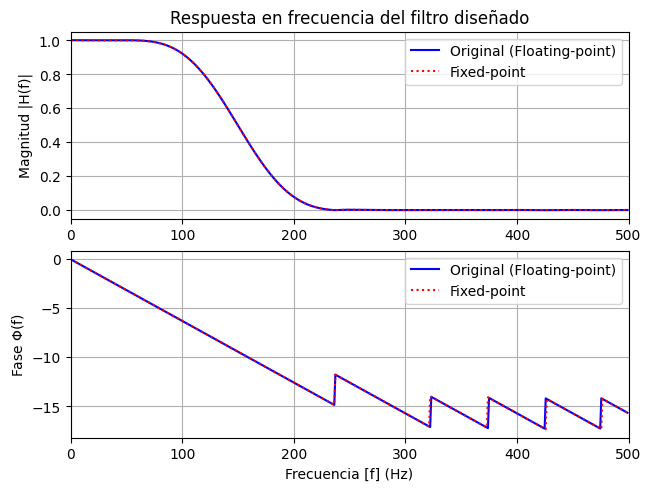

In [3]:
#Ejemplo 6.1 (Parte B). Cuantización de los coeficientes de un filtros FIR en punto fijo

#Conversión a punto fijo de los coeficientes
h_fix = np.fix(hw * (np.power(2, F)-1))

#Grafica la respuesta en frecuencia en Hertz para la versión original y en punto fijo
w, Hw = sig.freqz(hw)
wfix, Hwfix = sig.freqz(h_fix, np.power(2,F))

fig, axs = plt.subplots(2,1,layout='constrained')
axs[0].plot((fs/2) * w/np.pi, np.abs(Hw), 'b-', label='Original (Floating-point)')
axs[0].plot((fs/2) * wfix/np.pi, np.abs(Hwfix), 'r:', label='Fixed-point')
axs[0].set_ylabel(r'Magnitud |H(f)|')
axs[0].set_title('Respuesta en frecuencia del filtro diseñado')
axs[0].set(xlim=(0,fs/2))
axs[0].grid()
axs[0].legend()
axs[1].plot((fs/2) * w/np.pi, np.unwrap(np.angle(Hw)), 'b-', label='Original (Floating-point)')
axs[1].plot((fs/2) * wfix/np.pi, np.unwrap(np.angle(Hwfix)), 'r:', label='Fixed-point')
axs[1].set_xlabel(r'Frecuencia [f] (Hz)')
axs[1].set_ylabel(r'Fase $\Phi$(f)')
axs[1].set(xlim=(0,fs/2))
axs[1].grid()
axs[1].legend()
plt.show()

#Exporta los coeficientes al archivo coeffs_fix.h
with open('coeffs_fir_fix.h', 'w') as file:
    file.write(f'#define Nh_fix {len(h_fix)}\n')
    file.write('const int16_t h_fix[] = {\n')
    for hsample in h_fix:
        file.write(f"\t {int(hsample)}, \n")
    file.write('};\n')
    file.close()

### 6.1.2. Cuantización de la señal de entrada

La cuantización de la señal de entrada se realiza por hardware en el conversor analógico-digital y depende del número de bits de dicho conversor. Aunque dicha señal se podría modelar como una amplitud en voltios, para efectos de análisis e implementación de los algoritmos es más simple asumir que la señal de entrada está normalizada al voltaje de referencia del conversor ADC, es decir, que su rango es $$|x[n]| \leq 1$$

De esta forma, si tenemos un conversor de 16 bits, cuyo rango numérico con signo es $-2^{15}...2^{15}-1$, el número $-2^{15}$ está asociado a la amplitud $-1$ y $2^{15}-1$ a la amplitud 1. En la práctica, los conversores de 16 bits con signo están disponibles sólo en ciertas plataformas como PC o señales pre-grabadas de audio. Por su parte, en sistemas embebidos se usa un número de bits mucho menor y sin signo. Por ejemplo, en un sistema Arduino UNO el conversor ADC es de 10bits y en una ESP32, es de 12 bits, ambos sin signo. Para convertir la lectura de un ADC sin signo a signo basta con restarle $2^{n_{bits-conversor}-1}$ al número:

``x_signo = analogRead(ADC_CH) - (1<<(Nbitsconv-1));``

No siempre es necesario hacer esta conversión, solamente es necesaria en aquellos casos que el algoritmo sea sensible al nivel de DC, ya que su efecto sobre el espectro en frecuencia es alterar únicamente la componente de frecuencia cero.  

Una vez hecha esta conversión, y para efectos de análisis de los algoritmos, se asume que la señal de entrada está representada en notación $$Q(1,0,n_{bits-conversor}-1)$$ 

Por ejemplo, en una ESP32, al tener un ADC de 12 bits, la señal de entrada está expresada como $Q(1,0,11)$.

### 6.1.3. Codificación del algoritmo

Una forma simple de codificar los algoritmos en punto fijo es partir del algoritmo base en punto flotante e identificar en cada operación la representación en punto fijo de cada variable intermedia, partiendo de la representación en punto fijo de la entrada y los coeficientes antes calculados.

En la siguiente figura se muestra el procedimiento. Por ejemplo, para implementar el filtro de la Sección 6.1.1 usando una ESP32, se llegó a la conclusión de que la entrada del ADC está en una representación $Q(1,0,11)$ y los coeficientes, $h$, en representación $Q(1,1,14)$, lo cual se muestra en la figura de la izquierda en amarillo. Con estos valores se infiere que el vector ``x`` debe tener también una representación $Q(1,0,11)$, mostrada en verde, y el resultado del término  del ciclo for más interno ``y += h[k]*x[k];`` tendrá una representación con un punto fijo de $F=F_{1}+F_{2}=14+11=25$ bits en la parte fraccionaria, lo cual se muestra en el recuadro en naranja. Por ahora, no nos interesa saber cuantos bits se requieren en la parte entera. Finalmente, es importante notar que si ``y`` tendrá una representación $Q(1,x,25)$, la señal que devuelve la función debe tener una representación igual a la señal de entrada, es decir $Q(1,0,11)$ de allí que al final hay que hacer una conversión de $Q(1,x,25)$ a $Q(1,0,11)$, indicada en el recuadro en azul. 

![Flujo de Diseño/Implementación de un filtro digital](../img/cap6_fir_fix_point.png)

El segundo paso es analizar el tipo de variables que se usarán para estas representaciones en punto fijo. En este caso, la señal de entrada y los coeficientes tendrán 12 y 16 bits, respectivamente, por lo cual se pueden expresar en variables de 16 bits, o sea, el tipo ``int16_t``. Esto mismo aplica para el vector ``x``. Sin embargo, la variable ``y``, al tener una representación $Q(1,x,25)$ se debe alojar en una variable de 32 bits, o ``int32_t``, esto nos como resultado una representación final de $Q(1,8,25)$, es decir, la parte entera es de 8 bits lo cual nos da un buen margen de bits de guarda para evitar desborde en la sumatoria.

Finalmente, lo que se hace es cambiar las declaraciones de estas variables de ``float`` a los valores ``int16_t`` e ``int32_t`` que se identificaron en el paso anterior. Para que el producto de ``h[k]`` y ``x[k]`` se haga correctamente, es necesario usar cast con  ``int32_t`` para decirle al compilador que use operaciones de 32 bits. Finalmente, puede notarse que para retornar una salida en notación $Q(1,8,25)$ a $Q(1,0,11)$ es necesario eliminar $F=25-11=14$ bits, por ello se hace al final un corrimiento de 14 bits a la derecha.

El código final se presenta a continuación y puede verificarse en Wokwi en el siguiente enlace https://wokwi.com/projects/421165936829225985.

```C
int16_t x_fix[Nh_fix];

int16_t filter_fix(int16_t x_ADC) {
    int k;
    int32_t y;
    x_fix[0] = x_ADC;
    //Compute convolution
    y = 0;
    for(k=0; k<Nh_fix; k++) {
        y += (int32_t)h_fix[k]*(int32_t)x_fix[k];
    }
    //Delay elements in the array x
    for(k=Nh_fix-1; k>0; k--) {
        x_fix[k] = x_fix[k-1];
    }
    return y >> 14;
}
```

## 6.2 Punto Fijo en Filtros IIR

En la implementación en punto fijo de los filtros digitales IIR se hace un procedimiento similar al de los filtros FIR mostrado en la sección anterior, sin embargo, hay algunos cambios sutiles como se mostrará a continuación.

### 6.2.1. Cuantización de los coeficientes

Si la unidad aritmético lógica del procesador donde se ejecutará el programa tiene un ancho de n bits, lo ideal es expresar los coeficientes como cantidades enteras con signo de esta misma cantidad de bits. Por consiguiente, si el factor de escalamiento es $2^{F}$ se requiere que el producto entre dicho factor y el mayor de los coeficientes sea una cantidad que se pueda expresar en un registro de n bits con signo. Esto en términos matemáticos es:

$$2^{F}\max\left|coeficientes\right|<2^{n-1}$$

lo que conduce a:

$$F<(n-1)-\log_{2}\left\{ \max\left|coeficientes\right|\right\}$$ 

En el siguiente ejemplo se muestra cómo hacer este procedimiento en un filtro IIR.

In [4]:
# Ejemplo 6.2 (Parte A). Cuantización de los coeficientes de un filtro IIR en punto fijo.
# 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

#Cálculo de un filtro pasa-bajo IIR de fc=150Hz @ fs=1kHz de la familia Butterworth
fs = 1000
fc = 150
N = 10

b, a = sig.butter(N, fc, 'lowpass', fs=fs)

print('Coeficientes')
print(a)
print(b)

#Cálculo de F
nbits = 16
maxval = np.max( [np.max(np.abs(a)), np.max(np.abs(b))] )
print(f'Máximo valor={maxval}')

F = (nbits-1) - np.log2(maxval)
print(f'Número de bits parte fraccionaria F: {F}')

Coeficientes
[ 1.00000000e+00 -3.98765437e+00  8.09440659e+00 -1.04762754e+01
  9.42333716e+00 -6.08421408e+00  2.83526165e+00 -9.36403463e-01
  2.08912325e-01 -2.83358587e-02  1.76963187e-03]
[4.96135121e-05 4.96135121e-04 2.23260804e-03 5.95362145e-03
 1.04188375e-02 1.25026050e-02 1.04188375e-02 5.95362145e-03
 2.23260804e-03 4.96135121e-04 4.96135121e-05]
Máximo valor=10.476275357112572
Número de bits parte fraccionaria F: 11.610946020196941


Nótese que en programa anterior $F=11.6109$ por lo cual, para cumplir la condición es necesario hacer un redondeo por debajo, es decir, $F=11$, ya que un redondeo por encima produciría desborde en la cuantización de los coeficientes, no siendo posible expresarlos en 16 bits. En este caso, los coeficientes están representados en notación $Q(1,4,11)$.

Un paso importante en el procedimiento de cuantización es analizar el efecto que esta tiene sobre la respuesta en frecuencia. En el siguiente programa en Python se muestra como hacer la cuantización de los coeficientes $a_{k}$ y $b_{k}$ y se calcula la respuesta en frecuencia y ubicación de polos y ceros para el filtro antes de hacer la cuantización y después de hacerla.

Nótese que a diferencia con los filtros FIR, los IIR son muy susceptibles a cuantización de los coeficientes, ya que los polos se desplazan de sus posiciones originales, lo cual puede conducir a implementaciones inestables. De allí que sea indispensable hacer una verificación rigurosa cuando se implementa un filtro IIR en punto fijo y usar estructuras de implementación que sean menos sensibles a efectos de cuantización como la estructura en cascada.

Coeficientes Punto Fijo
[ 2.0470e+03 -8.1620e+03  1.6569e+04 -2.1444e+04  1.9289e+04 -1.2454e+04
  5.8030e+03 -1.9160e+03  4.2700e+02 -5.8000e+01  3.0000e+00]
[ 0.  1.  4. 12. 21. 25. 21. 12.  4.  1.  0.]


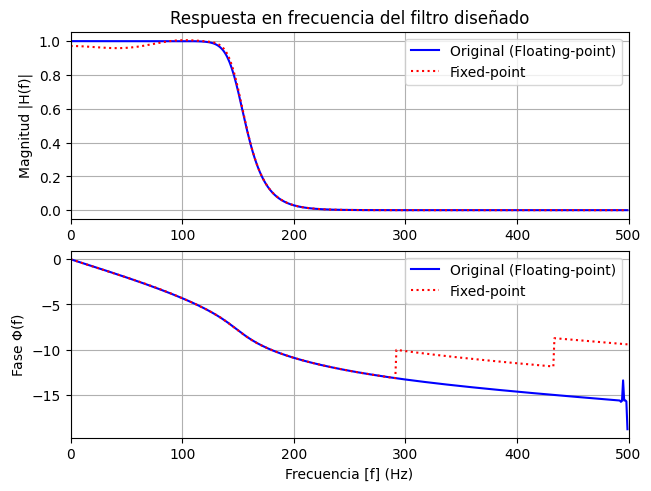

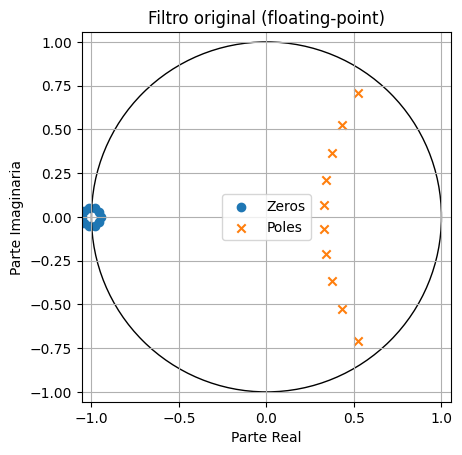

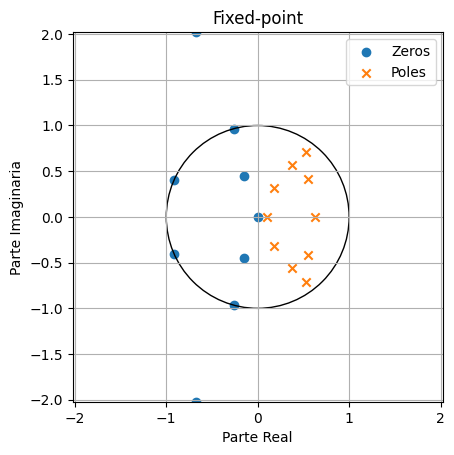

In [6]:
#Ejemplo 6.2 (Parte B). Cuantización de los coeficientes de un filtros IIR en punto fijo

#Conversión a punto fijo de los coeficientes
F = 11
a_fix = np.fix(a * (np.power(2, F)-1))
b_fix = np.fix(b * (np.power(2, F)-1))

print('Coeficientes Punto Fijo')
print(a_fix)
print(b_fix)

#Grafica la respuesta en frecuencia en Hertz para la versión original y en punto fijo
w, Hw = sig.freqz(b,a)
wfix, Hwfix = sig.freqz(b_fix, a_fix)

fig, axs = plt.subplots(2,1,layout='constrained')
axs[0].plot((fs/2) * w/np.pi, np.abs(Hw), 'b-', label='Original (Floating-point)')
axs[0].plot((fs/2) * wfix/np.pi, np.abs(Hwfix), 'r:', label='Fixed-point')
axs[0].set_ylabel(r'Magnitud |H(f)|')
axs[0].set_title('Respuesta en frecuencia del filtro diseñado')
axs[0].set(xlim=(0,fs/2))
axs[0].grid()
axs[0].legend()
axs[1].plot((fs/2) * w/np.pi, np.unwrap(np.angle(Hw)), 'b-', label='Original (Floating-point)')
axs[1].plot((fs/2) * wfix/np.pi, np.unwrap(np.angle(Hwfix)), 'r:', label='Fixed-point')
axs[1].set_xlabel(r'Frecuencia [f] (Hz)')
axs[1].set_ylabel(r'Fase $\Phi$(f)')
axs[1].set(xlim=(0,fs/2))
axs[1].grid()
axs[1].legend()
plt.show()

#Grafica la ubicación de polos y ceros de la versión original y en punto fijo

sys = sig.TransferFunction(b, a, dt=1/fs)
sys_fix = sig.TransferFunction(b_fix, a_fix, dt=1/fs)

def zplane(sys, title):
    #Grafica la ubicación de polos y ceros
    fig, ax = plt.subplots()
    ax.scatter(sys.zeros.real, sys.zeros.imag, marker='o', label='Zeros')
    ax.scatter(sys.poles.real, sys.poles.imag, marker='x', label='Poles')
    ax.set_xlabel('Parte Real')
    ax.set_ylabel('Parte Imaginaria')
    ax.grid(True)
    ax.legend()
    ax.set_title(title)
    #Superpone el círculo unitario
    unit_circle = plt.Circle((0, 0), 1 , fill = False)
    ax.set_aspect(1)
    ax.add_artist(unit_circle)
    maxv = np.max([np.max(np.abs(sys.zeros.real)), np.max(np.abs(sys.zeros.imag)), np.max(np.abs(sys.poles.real)), np.max(np.abs(sys.zeros.imag)), 1])
    ax.set(xlim=(-maxv,maxv), ylim=(-maxv,maxv))
    plt.show()

zplane(sys, 'Filtro original (floating-point)')
zplane(sys_fix, 'Fixed-point')

#Exporta los coeficientes al archivo coeffs_iir_fix.h
with open('coeffs_iir_fix.h', 'w') as file:
    file.write(f'#define N_fix {len(a_fix)}\n')
    file.write('const int16_t a_fix[] = {\n')
    for sample in a_fix:
        file.write(f"\t {int(sample)}, \n")
    file.write('};\n')
    file.write('const int16_t b_fix[] = {\n')
    for sample in b_fix:
        file.write(f"\t {int(sample)}, \n")
    file.write('};\n')
    file.close()

### 6.2.2. Cuantización de la señal de entrada

Se aplican los mismos principios del filtro FIR (Ver Sección 6.1.2).

### 6.2.3. Codificación del algoritmo

Para reescribir un algoritmo a punto fijo de un filtro IIR, o cualquier tipo de filtro, se pueden seguir los siguientes pasos: 

1. Definir las variables en las cuales se almacenan los resultados de un MAC como registros de $2n$ bits, ya que el producto de dos variables de $n$ bits es una cantidad que se expresa en $2n$ bits.

2. Escribir el programa para una versión en punto flotante e identificar el tipo de datos apropiado para cada variable según el número de bits requerido.

3. Reescribir la ecuación en diferencias cambiando cada coeficiente $c_{i}$ por $2^{F}c_{i}$, dado que los coeficientes están afectados por el factor de escala $2^{F}$, e introducir una división por $2^{F}$ u otro tipo de operación que garantice que la ecuación matemática resultante sea exactamente igual a la ecuación en diferencias original.

4. Cambiar cada término $2^{F}c_{i}$ por $cp_{i}$. En la nueva ecuación en diferencias, identificar aquellos términos que quedan con el producto $2^{F}$ y la división por $2^{F}$. En el algoritmo, cambiar todos los productos por $2^{F}$ por un corrimiento hacia la izquierda $F$ bits, y las divisiones por corrimientos hacia la derecha $F$ bits.

5. Finalmente, incluir modeladores en todos los productos y corrimientos hacia la izquierda.

Para ilustrar la técnica descrita anteriormente, veamos como implementar el filtro digital IIR por medio de la estructura directa tipo II. En este caso, las ecuaciones en diferencia de la estructura directa tipo II son: 

$$\begin{array}{r}
w[n]=x[n]-a_{1}w[n-1]-...-a_{N-1}w[n-N+1]\\
y[n]=b_{0}w[n]+b_{1}w[n-1]+...+b_{N-1}w[n-N+1]
\end{array}$$


**Paso 1**. El procesador donde se va a ejecutar el programa tiene una unidad aritmético-lógica de 16 bits, por lo que el formato en C para almacenar los coeficientes será el tipo ``int16_t`` y para los registros o variables acumuladores ``int32_t`` (32bits). 


**Paso 2**. La versión en punto flotante de las ecuaciones en diferencia presentadas es:

```C
float w[N];
float ak[N] = { ... };
float bk[N] = { ... };

float filter(float x_ADC) {
      int k;
      float yn, wn;
      wn = x_ADC;
      for(k=N-1; k>=1; k--) {
            wn -= ak[k] * w[k];
      }
      w[0]=wn;
      yn=0;
      for(k=N-1; k>=0; k--) {
            yn += bk[k] * w[k];
      }
      for(k=N-1; k>=1; k--) {
            w[k]=w[k-1];
      }
      return yn;
}
```

En este programa se identifica que las variables ``yn`` y ``wn`` son las variables acumuladoras de los MAC, por lo que en la versión en punto fijo estas serán definidas como variables tipo ``int32_t``. Todas las restantes variables serán tipo ``int16_t``.


**Paso 3**. Reescribiendo las ecuaciones en diferencias al implicar el término $2^{F}$ en los coeficientes:

$$\begin{array}{r}
w[n]=(x[n]-2^{F}a_{1}w[n-1]-...-2^{F}a_{N-1}w[n-N+1])/2^{F}\\
y[n]=(2^{F}b_{0}w[n]+2^{F}b_{1}w[n-1]+...+2^{F}b_{N-1}w[n-N+1])/2^{F}
\end{array}$$

Nótese que la primera ecuación no es matemáticamente correcta, pues el término $x[n]$ quedaría afectado por un factor $1/2^{F}$. Para corregirlo, la primera ecuación en diferencias debe ser:

$$\begin{array}{r}
w[n]=(2^{F}x[n]-2^{F}a_{1}w[n-1]-...-2^{F}a_{N-1}w[n-N+1])/2^{F}\\
y[n]=(2^{F}b_{0}w[n]+2^{F}b_{1}w[n-1]+...+2^{F}b_{N-1}w[n-N+1])/2^{F}
\end{array}$$

**Paso 4**. Modificando las ecuaciones en diferencias anteriores, tenemos que:

$$\begin{array}{r}
w[n]=(2^{F}x[n]-ap_{1}w[n-1]-...-ap_{N-1}w[n-N+1])/2^{F}\\
y[n]=(bp_{0}w[n]+bp_{1}w[n-1]+...+bp_{N-1}w[n-N+1])/2^{F}
\end{array}$$

Por lo que al algoritmo en punto fijo habría que incluir un corrimiento hacia la izquierda en la entrada actual $x[n]$, es decir, la línea de código ``wn = x_ADC`` se debe sustituir por ``wn = x_ADC<<F``; como $w[n]$ está almacenado en la variable ``wn``, una vez finaliza el primer ciclo ``for``, es necesario realizar un corrimiento hacia la derecha que represente el término $/2^{F}$ en la primer ecuación en diferencias, es decir, la línea de código ``w[0]=wn`` debe ser reescrita como ``w[0]=wn>>F``; por último, la línea de código ``return yn`` debe ser reescrita como ``return yn>>F`` para incluir el término $/2^{F}$ de la segunda ecuación en diferencias.

**Paso 5**. El programa corregido, incluyendo los modeladores será entonces:

```C
#define F 11  //Factor de escalamiento
int16_t w[N];
int16_t ak[N] = { ... };
int16_t bk[N] = { ... };

int16_t filter_iir_fix(int16_t x_ADC) {
       int k;
       int32_t yn, wn;
       wn = (int32_t)x_ADC << (F-G);
       for(k=N-1; k>=1; k--) {
              wn -= ((int32_t)ak[k]) * ((int32_t)w[k]);
       }
       w[0] = wn >> F;
       yn=0;
       for(k=N-1; k>=0; k--) {
              yn += ((int32_t)bk[k]) * ((int32_t)w[k]);
       }
       for(k=N-1; k>=1; k--) {
              w[k]=w[k-1];
       }
       return yn >> (F-G);
}
```

Como se analizará a continuación, el procedimiento antes descrito garantiza la obtención de un algoritmo matemáticamente correcto, una mayor precisión en los cálculos y un ahorro de memoria y número de instrucciones de máquina, pero requiere algunos ajustes para evitar desborde.

En primera medida, la línea de código ``w[0] = wn >> F`` tiene dos fines, primero garantizar la estructura correcta de las ecuaciones en diferencia y segundo, almacenar cada uno de los elementos del nodo de retardo $w[n]$ en una representación de punto fijo igual a la de la señal de entrada y con una menor cantidad de bits. 

Aunque los modeladores ``(int32_t)`` se habrían podido eliminar declarando tipo ``int32_t`` los arreglos ``ak``, ``bk`` y ``w``. Esta asignación no es práctica, pues además de consumir mayor espacio en memoria, hace que el compilador emplee instrucciones de acceso a memoria de 32bits, que resultan en un mayor número de instrucciones de máquina y por ende una menor velocidad de ejecución.

Por otra parte, para no perder precisión al evaluar las sumatorias, el desplazamiento ``>>F`` se realiza al finalizar el ciclo ``for`` y no en cada iteración. Asimismo, se deben realizar las multiplicaciones a 32bits, de allí que las variables ``wn`` y ``yn`` se hayan declarado como tipo ``int32_t`` y empleado los modeladores ``(int32_t)`` al realizar los productos. 

Puesto que las sumatorias se realizan en punto fijo, es necesario garantizar la suficiente cantidad de bits de guarda para evitar el desborde al realizar las sumatorias. En el ejemplo anterior, como los coeficientes están en notación $Q(1,4,11)$ y la señal de entrada en notación $Q(1,0,15)$, las variables ``wn`` y ``yn`` estarán en notación $Q(1,5,26)$. Con $I=5$ bits en la parte entera, se puede representar números en el rango $-2^{I}...2^{I}$, es decir, $-32...32$ en el ejemplo. Así que cualquier resultado intermedio del primer ciclo ``for`` que produzca un ``wn`` que supere este rango producirá desborde. 

Lo anterior evidencia que se hace necesario analizar la existencia o no de desborde, y de presentarse, es necesario añadir **bits de guarda** como se mostrará a continuación.

Estos bits de guarda compensan la ganancia que trae implícita cada de las sumatorias de la ecuación en diferencias. En el ejemplo anterior, el filtro total IIR, $H(z)=B(z)/A(z)$, se diseñó para tener ganancia unitaria (como se evidencia en la respuesta en frecuencia), pero al implementarse en dos ciclos ``for``, uno con $a_{k}$ y otro con $b_{k}$, no implica que cada etapa sean filtros de ganancia unitaria. En la primera etapa, el ciclo ``for`` con $a_{k}$, se comporta como un filtro cuya función de transferencia es $1/A(z)$ y su ganancia es generalmente mayor a 1; mientras que el segundo filtro, el ciclo ``for`` con $b_{k}$, es un filtro con función de transferencia $B(z)$, cuya ganancia es generalmente menor a 1. Este efecto se muestra en el siguiente programa.

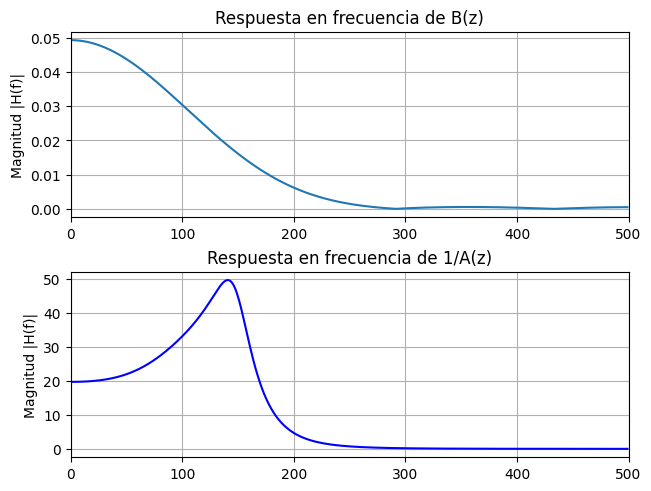

In [8]:
# Ejemplo 6.2 (Parte C). Cuantización de los coeficientes de un filtros IIR en punto fijo.
# Ganancias implícitas de cada etapa en la implementación

#Grafica la respuesta en frecuencia del componente B(z) y 1/A(z) de manera independiente 
wb, Hwb = sig.freqz(b_fix,np.power(2,F))
wa, Hwa = sig.freqz(np.power(2,F),a_fix)

fig, axs = plt.subplots(2,1,layout='constrained')
axs[0].plot((fs/2) * wb/np.pi, np.abs(Hwb))
axs[0].set_ylabel(r'Magnitud |H(f)|')
axs[0].set_title('Respuesta en frecuencia de B(z)')
axs[0].set(xlim=(0,fs/2))
axs[0].grid()
axs[1].plot((fs/2) * wa/np.pi, np.abs(Hwa), 'b-', label='1/A(z)')
axs[1].set_ylabel(r'Magnitud |H(f)|')
axs[1].set_title('Respuesta en frecuencia de 1/A(z)')
axs[1].set(xlim=(0,fs/2))
axs[1].grid()
plt.show()

Note que la componente $1/A(z)$, que corresponde al primer ciclo ``for``, tiene una ganancia cercana a 50. Esto significa que si la entrada tiene un amplitud máxima de 1, como se indicó en la Sección 6.1.2, el primer ciclo ``for`` generará una señal que supera la máxima amplitud que se puede almacenar en la variable ``wn``, la cual es $32=2^{5}$ por que ``wn`` tiene una representación $Q(1,5,26)$. Esto muestra la necesidad de incluir bits de guarda. El número potencia de dos por encima de la ganancia de $50$ es $64 = 2^{6}$, por lo tanto, son necesarios $6-5=1$ bits de guarda. En la práctica, se prefiere adicionar un bit más de guarda para evitar problemas de desborde debido a las acumulaciones. En este caso, se requieren entonces $G=2$ bits de guarda.

Para lograrlo, se debe reducir la amplitud de la señal de entrada $2^{G}=2^{2}=4$ veces con el fin de evitar desborde en los cálculos del primer ciclo ``for``. Esta reducción se puede compensar al final del algoritmo aplicando una amplificación por el mismo factor. Una forma simple de incluir esta reducción y amplificación es cambiar las líneas ``wn = x_ADC<<F`` por ``wn = x_ADC<<(F-G)``, y ``return y>>F`` por ``return y>>(F-G)``, es decir, se cambia el número $11$ por $11-2=9$.

El algoritmo final será entonces:

```C
#define F 11    //Factor de escalamiento
#define G 2     //Bits de guarda
int16_t w[N];
int16_t ak[N] = { ... };
int16_t bk[N] = { ... };

int16_t filter_iir_fix(int16_t x_ADC) {
       int k;
       int32_t yn, wn;
       wn = (int32_t)x_ADC << (F-G);
       for(k=N-1; k>=1; k--) {
              wn -= ((int32_t)ak[k]) * ((int32_t)w[k]);
       }
       w[0] = wn >> F;
       yn=0;
       for(k=N-1; k>=0; k--) {
              yn += ((int32_t)bk[k]) * ((int32_t)w[k]);
       }
       for(k=N-1; k>=1; k--) {
              w[k]=w[k-1];
       }
       return yn >> (F-G);
}
```

Este programa puede verificarse en el siguiente enlace en Wokwi: https://wokwi.com/projects/421166496960743425

#### Para Reflexionar

* Realice la implementación del filtro del Ejemplo 6.2, en punto fijo, usando la estructura en cascada mediante adaptaciones al programa de referencia https://wokwi.com/projects/421166496960743425. Consulte la Sección 5.4 del capítulo anterior para conocer como generar los coeficientes de la estructura en cascada. 

## 6.3. Truncamiento y Redondeo

La conversión de los números en una representación en punto fijo con $F1$ bits en la parte fraccionaria a una con menor número de bits $F2<F1$ implica realizar desplazamientos hacia la derecha que descartan bits, lo que produce una pérdida de precisión. Esta pérdida de precisión no es tan relevante en filtros FIR pero si lo es en filtros IIR.

El efecto de desplazar ``F`` bits a la derecha se conoce con el nombre de **truncamiento** y produce generalmente soluciones poco precisas. Una forma de mejorar la precisión es incluir **redondeo**, lo cual se hace de manera sencilla sumando $0.5$, en representación en punto fijo, al número antes de hacer el truncamiento, es decir, se hace la suma con $2^{F-1}$.  En la siguiente tabla se muestran ejemplos de truncamiento y redondeo en lenguaje C.

| Operación | Codificación en Lenguaje C | 
|------|------|
| Truncamiento	| ``x >> F`` |
| Truncamiento	| ``x >> 13`` |
| Redondeo	| ``(x+(1<<(F-1))) >> F`` | 
| Redondeo	| ``(x+4096) >> 13`` donde $4096=2^{12}$ |

## 6.4. Aspectos Importantes en la Codificación de Desplazamientos 

Para codificar correctamente los desplazamientos en lenguaje C hay que tener presente las siguientes precauciones:

1. Para desplazar una variable de 16bits hacia la izquierda se debe convertir inicialmente a 32bits antes del corrimiento, de no ser así, el desplazamiento se realiza a 16bits y se perderán los bits superiores. Esto es, la instrucción 

``int32_t y = x << 9;``

es incorrecta, y debe ser reescrita como:

``int32_t y = (int32_t) x << 9;``

2. Se recomienda agrupar entre paréntesis cada uno de los desplazamientos individuales, por ejemplo, para implementar la E.D. $y[n]=x[n]+k\,y[n-1]$ una forma aparentemente correcta sería:

``y = ( (int32_t)x<<13 + (int32_t)k*(int32_t)y[1] )>>13;``

pero al ejecutar el programa no funciona, ya que el compilador asume que el desplazamiento de x es 13+k*y[1] bits hacia la izquierda y no  3 como era de esperarse, en su lugar debe escribirse como:

``y = ( ((int32_t)x<<13) + (int32_t)k*(int32_t)y[1] )>>13;``

3. Finalmente, para escribir la E.D. $y[n]=b_{0}x[n]-a_{1}y[n-1]$ una forma posible, pero que trae consigo la pérdida de precisión es:

``y =(((int32_t)b0*(int32_t)x)>>13) + (((int32_t)a1*(int32_t)y[1])>>13);``

ya que cuando se trabaja con punto fijo se recomienda efectuar las sumas con los cantidades afectadas por el factor de escala y al finalizar, eliminarlo por medio de un desplazamiento hacia la derecha. De esta forma una implementación más eficiente es:

``y = ( (int32_t)b0*(int32_t)x + (int32_t)a1*(int32_t)y[1] ) >>13;``